This Notebook is for visualization purposes of 4dstem tomography data

In [1]:
#use this for interactive pop up images
#%matplotlib qt5

In [2]:
import hyperspy.api as hs
import pyxem as pxm
import numpy as np
import SimpleITK as sitk
from matplotlib import pyplot as plt
import pandas as pd
import time
import gc
import os
from os.path import exists
from scipy.spatial.transform import Rotation
from numpy.linalg import norm
import h5py
import dask.array as da
from skimage.transform import resize
import mrcfile
import pyclesperanto_prototype as cle
cle.select_device("GTX")

<NVIDIA GeForce GTX 1050 Ti on Platform: NVIDIA CUDA (1 refs)>

In [17]:
#load the reconstruction
reco = hs.load("D:/data/August2022/TiNi/tomo/sirt10cut.tif")
reco.set_signal_type('electron_diffraction')


In [18]:
#resize the reconstruction to match the meanscale below
meanscale = 0.7163452999020451
recbo = resize(reco.data, ( np.round(meanscale*(reco.data.shape[0] / 4)), np.round(meanscale*(reco.data.shape[1] / 4)), np.round(meanscale*(reco.data.shape[2] / 4))), anti_aliasing=True)
recbo = hs.signals.Signal2D(recbo)
recbo.set_signal_type('electron_diffraction')
#recb.plot(cmap='gray')
recbz, recby, recbx = recbo.data.shape
del reco
del recbo
gc.collect()

3146

In [7]:
#spherical mask
def sphere(shape, radius, position):
    """Generate an n-dimensional spherical mask."""
    # assume shape and position have the same length and contain ints
    # the units are pixels / voxels (px for short)
    # radius is a int or float in px
    assert len(position) == len(shape)
    n = len(shape)
    semisizes = (radius,) * len(shape)

    # genereate the grid for the support points
    # centered at the position indicated by position
    grid = [slice(-x0, dim - x0) for x0, dim in zip(position, shape)]
    position = np.ogrid[grid]
    # calculate the distance of all points from `position` center
    # scaled by the radius
    arr = np.zeros(shape, dtype=float)
    for x_i, semisize in zip(position, semisizes):
        # this can be generalized for exponent != 2
        # in which case `(x_i / semisize)`
        # would become `np.abs(x_i / semisize)`
        arr += (x_i / semisize) ** 2

    # the inner part of the sphere will have distance below or equal to 1
    return arr <= 1.0

In [9]:
#scut1 is a spherical mask from 0 to 6 radially to calculate the bright field 3d virtual image
#scut2 is a spherical mask from 6 to 128 radially to calculate the dark field 3d virtual image
pos = (128,128,128)

r3 = 6
r4 = 128
s1 = sphere((256,256,256), r3,pos)
s2 = sphere((256,256,256), r4,pos)
s3 = np.logical_xor(s1,s2)

scut1 = s1[pos[0] - int(r3)  :pos[0] + int(r3) + 1 ,pos[1] - int(r3) :pos[1] + int(r3)  + 1,pos[2] - int(r3) :pos[2] + int(r3)  + 1]

scut2 = s3[pos[0] - int(r4) :pos[0] + int(r4) + 1,pos[1] - int(r4) :pos[1] + int(r4) + 1,pos[2] - int(r4) :pos[2] + int(r4) + 1]

del s2
del s1
del s3
gc.collect()  

496

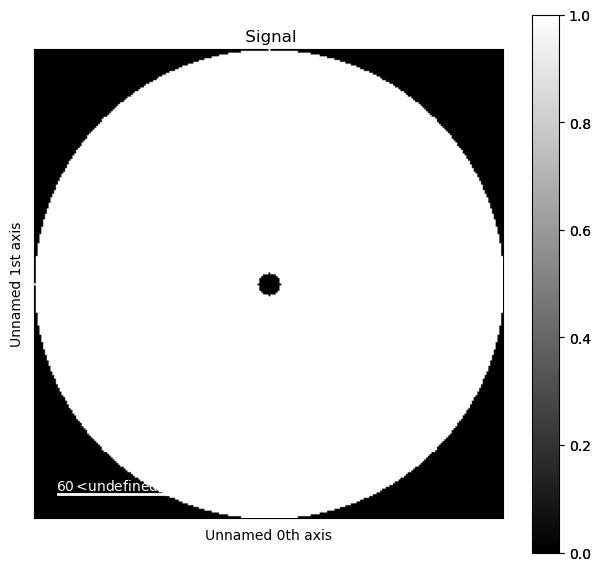

In [12]:
recbo = hs.signals.Signal2D(scut2)
recbo.set_signal_type('electron_diffraction')
recbo.inav[128].plot(cmap='gray')

In [20]:
rec1 = np.zeros((recbz, recby, recbx))
rec2 = np.zeros((recbz, recby, recbx))

In [ ]:
#calculate the 3d virtual images

#Change path here from Reconstruction.ipynb
outpath3 = 'D:/data/August2022/TiNi/tomo/Tomo_23/Rec_Planes/'


for z in range(recbz): 
    print('plane',z)
    
    for j in range(recby): 
        for i in range(recbx): 
            
            #mrcpath = 'D:/data/August2022/TiNi/tomo/Tomo_23/Rec_Planes/' + str(z) + '/'
            mrcpath = outpath3 + str(z) + '/'
            name = 'box_' + '_j_' + str(j) + '_i_' + str(i) + '.mrc'
            
            if exists(mrcpath + name):
                dp3d  = mrcfile.open(mrcpath + name,'r+' )
                
                cut = dp3d.data[pos[0] - int(r2) :pos[0] + int(r2) + 1,pos[1] - int(r2) :pos[1] + int(r2) + 1,pos[2] - int(r2) :pos[2] + int(r2) + 1]*scut1
                rec1[z,j,i] = cut.sum()

                cut = dp3d.data[pos[0] - int(r4) :pos[0] + int(r4) + 1,pos[1] - int(r4) :pos[1] + int(r4) + 1,pos[2] - int(r4) :pos[2] + int(r4) + 1]*scut2
                rec2[z,j,i] = cut.sum()

                dp3d.close()

                

In [6]:
recbo = hs.signals.Signal2D(rec1)
recbo.set_signal_type('electron_diffraction')
recbo.plot(cmap='gray')

In [13]:
target1 = hs.signals.Signal2D(rec1)
test = 'rec_0-6newFINAL'
target1.save(outpath3 + test + '.hdf5', overwrite=True)
target1 = hs.signals.Signal2D(rec2)
test = 'rec_6-128newFINAL'
target1.save(outpath3 + test + '.hdf5', overwrite=True)

In [23]:
# Function to calculate 2D Virtual Images from 4DSTEM data and create a tilt series from them

#Change path here from Reconstruction.ipynb
outpath2 = 'D:/data/August2022/TiNi/tomo/Tomo_23/post2/'
Ntilts = 70

#Choose one:
roi = hs.roi.CircleROI(cx = 128.,cy = 128., r = 6.) #bright field 0 - 6 pix
#roi = hs.roi.CircleROI(cx = 128.,cy = 128., r_inner=128., r = 6.) #dark field 6 -128 pix

def write_vi_tiltseries():
  
    test = '4DSTEM_dp_tilt_noscale' 
    dp_tilt = hs.load(outpath2 + test + '.hdf5')

    path = outpath2 + 'transforms/' 
    
    test = '4DSTEM2_' + str(0)
    dp = hs.load(outpath2 + test +  '.hdf5')
    vi_tiltseries = np.zeros((Ntilts,dp.data.shape[0],dp.data.shape[1]))
    
    

    for tilt in range(vi_tiltseries.shape[0]):
             
        test = '4DSTEM2_' + str(tilt)
        dp = hs.load(outpath2 + test +  '.hdf5')

        test1 = 'transforms_' + str(tilt)
        Tx = sitk.ReadTransform(path + test1 + '.tfm')
        
        vdf = dp.get_integrated_intensity(roi=roi)
        
        resampler = sitk.ResampleImageFilter()
        moving = sitk.GetImageFromArray(vdf.data)
        resampler.SetReferenceImage(moving)
        resampler.SetInterpolator(sitk.sitkLinear)
        resampler.SetDefaultPixelValue(0.)
        resampler.SetTransform(Tx)

        outr = resampler.Execute(moving)
        out = sitk.GetArrayFromImage(outr)
        
        vi_tiltseries[tilt,:,:] = out

        del dp
        gc.collect()
        
    return vi_tiltseries
                      

In [24]:
#Do some code

vi_tiltseries = write_vi_tiltseries()
    

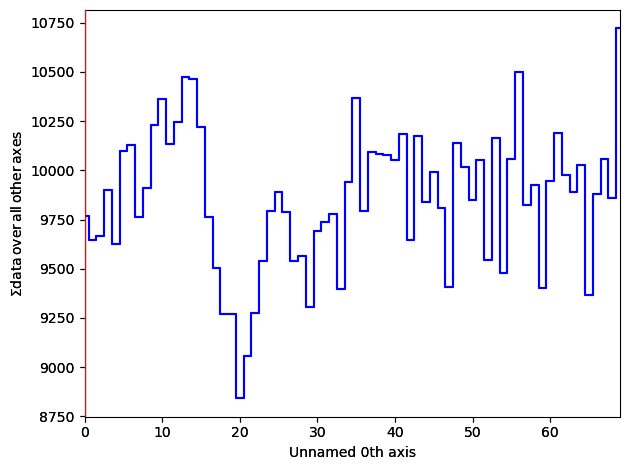

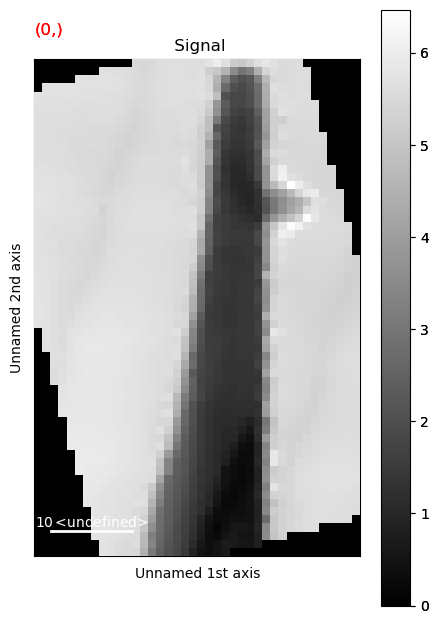

In [25]:
recbo = hs.signals.Signal2D(vi_tiltseries)
recbo.set_signal_type('electron_diffraction')
recbo.plot(cmap='gray')

In [21]:

name = 'vi_tiltseries'  + '.mrc'

dp3d  = mrcfile.new(outpath2 + name, vi_tiltseries.astype(np.float32),overwrite=True)
dp3d.close()